# K-Means

In [37]:
import pandas as pd
import math
import numpy as np
from matplotlib import pyplot as plt
from numpy import logical_and as land, logical_or as lor
import seaborn as sn
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans

In [2]:
from google.colab import drive
drive.mount('/content/drive')

DATA_PATH = '/content/drive/MyDrive/'

Mounted at /content/drive


In [23]:
df_indicators = pd.read_csv(DATA_PATH+'indicators.csv', sep='#')
df_tweets_ind = pd.read_csv(DATA_PATH+'tweets_with_indicators.csv', sep='#')
df_users = pd.read_csv(DATA_PATH+'users_clean.csv', sep='#')

In [24]:
df_indicators.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 222285 entries, 0 to 222284
Data columns (total 28 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   user_id              222285 non-null  object 
 1   n_tweets             222285 non-null  int64  
 2   2012_tweets          222285 non-null  int64  
 3   2013_tweets          222285 non-null  int64  
 4   2014_tweets          222285 non-null  int64  
 5   2015_tweets          222285 non-null  int64  
 6   2016_tweets          222285 non-null  int64  
 7   2017_tweets          222285 non-null  int64  
 8   2018_tweets          222285 non-null  int64  
 9   2019_tweets          222285 non-null  int64  
 10  2020_tweets          222285 non-null  int64  
 11  mean_length          222285 non-null  float64
 12  mean_special_chars   222285 non-null  float64
 13  retweets_count_mean  222285 non-null  float64
 14  retweets_count_std   17094 non-null   float64
 15  reply_count_mean 

In [86]:
df_users.id = df_users.id.astype(str)
df_merge = df_users.merge(df_indicators, left_on='id', right_on='user_id', how='left')

In [87]:
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11508 entries, 0 to 11507
Data columns (total 35 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   11508 non-null  object 
 1   name                 11507 non-null  object 
 2   lang                 11508 non-null  object 
 3   bot                  11508 non-null  int64  
 4   created_at           11508 non-null  object 
 5   statuses_count       11508 non-null  float64
 6   created_at_conv      11508 non-null  int64  
 7   user_id              11508 non-null  object 
 8   n_tweets             11508 non-null  int64  
 9   2012_tweets          11508 non-null  int64  
 10  2013_tweets          11508 non-null  int64  
 11  2014_tweets          11508 non-null  int64  
 12  2015_tweets          11508 non-null  int64  
 13  2016_tweets          11508 non-null  int64  
 14  2017_tweets          11508 non-null  int64  
 15  2018_tweets          11508 non-null 

Drop categorical columns

In [88]:
df_merge.drop(columns=['id', 'user_id', 'name', 'lang', 'created_at', 'bot'], inplace=True)
df_merge.drop(columns=[str(y)+'_tweets' for y in range(2012,2021)], inplace=True)

In [89]:
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11508 entries, 0 to 11507
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   statuses_count       11508 non-null  float64
 1   created_at_conv      11508 non-null  int64  
 2   n_tweets             11508 non-null  int64  
 3   mean_length          11508 non-null  float64
 4   mean_special_chars   11508 non-null  float64
 5   retweets_count_mean  11508 non-null  float64
 6   retweets_count_std   11414 non-null  float64
 7   reply_count_mean     11508 non-null  float64
 8   reply_count_std      11414 non-null  float64
 9   favorite_count_mean  11508 non-null  float64
 10  favorite_count_std   11414 non-null  float64
 11  num_hashtags_mean    11508 non-null  float64
 12  num_hashtags_std     11414 non-null  float64
 13  num_urls_mean        11508 non-null  float64
 14  num_urls_std         11414 non-null  float64
 15  num_mentions_mean    11508 non-null 

In [102]:
# (?????)

df_merge = df_merge.fillna(value=0)
df_merge.drop(columns=['created_at_conv', 'created_at_mean', 'created_at_std'], inplace=True)

Normalize values which have very different ranges

In [103]:
scaler = StandardScaler()
scaler.fit(df_merge.values)

StandardScaler()

In [104]:
df_merge.head()

,statuses_count,n_tweets,mean_length,mean_special_chars,retweets_count_mean,retweets_count_std,reply_count_mean,reply_count_std,favorite_count_mean,favorite_count_std,num_hashtags_mean,num_hashtags_std,num_urls_mean,num_urls_std,num_mentions_mean,num_mentions_std,max_daily_tweets
0,76.0,132,62.340909,3.696970,0.0,0.0,0.0,0.0,0.0,0.0,0.098485,0.443095,0.000000,0.000000,0.272727,0.447058,18
1,54.0,122,68.737705,3.278689,0.0,0.0,0.0,0.0,0.0,0.0,0.024590,0.155511,0.000000,0.000000,0.336066,0.474310,19
2,3.0,4,19.250000,4.750000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3
3,50.0,1439,86.731758,4.597637,0.0,0.0,0.0,0.0,0.0,0.0,0.077137,0.450959,0.024322,0.154102,0.006254,0.101941,155
4,7085.0,3656,72.181346,3.363512,0.0,0.0,0.0,0.0,0.0,0.0,0.124179,0.403006,0.000821,0.028638,0.505470,0.631566,52


In [105]:
df_merge_scaled = scaler.transform(df_merge.values)

In [106]:
df_merge_scaled

array([[-0.29867082, -0.66340037, -0.34714595, ..., -0.19588905,
         0.05119888, -0.39013964],
       [-0.29984298, -0.67122355,  0.04834401, ..., -0.01144658,
         0.13314198, -0.37938271],
       [-0.30256026, -0.76353707, -3.01129567, ..., -0.99007664,
        -1.29308895, -0.55149357],
       ...,
       [-0.30240042, -0.76119012,  0.25887184, ..., -0.1580706 ,
         0.17415852, -0.55149357],
       [-0.30048234, -0.68452296, -0.32465029, ...,  0.06379768,
         0.15884177, -0.44392428],
       [-0.02145513,  2.12321611, -0.98727231, ...,  1.10288929,
         0.94548894,  1.66443376]])

In [119]:
k = 2
kmeans = KMeans(n_clusters = k, n_init=10, max_iter=100)
kmeans.fit(df_merge_scaled)

KMeans(max_iter=100, n_clusters=2)

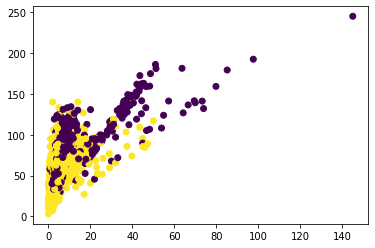

In [120]:
plt.scatter(df_merge['mean_special_chars'], df_merge['mean_length'], c=kmeans.labels_)
plt.show()

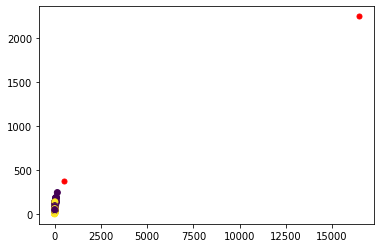

In [121]:
cent = scaler.inverse_transform(kmeans.cluster_centers_)

plt.scatter(df_merge['mean_special_chars'], df_merge['mean_length'], c=kmeans.labels_)
plt.scatter(cent[:, 0], cent[:, 1], s=100, marker='.', c='r')
plt.tick_params(axis='both', which='major')
plt.show()

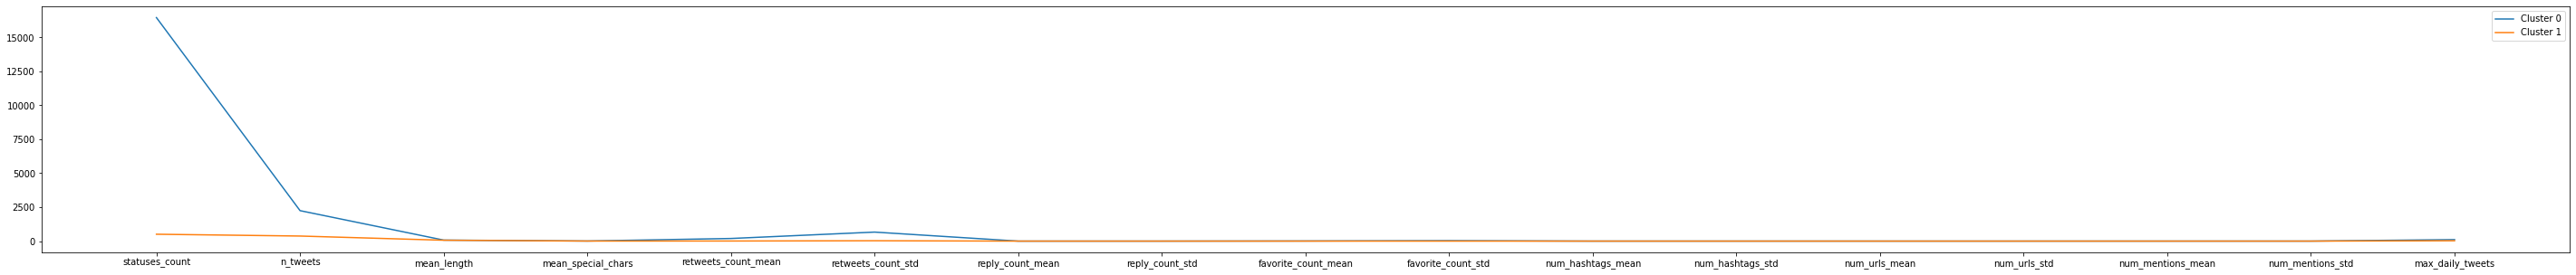

In [122]:
plt.figure(figsize=(50,5))
for i in range(0, len(cent)):
  plt.plot(cent[i], label="Cluster %s" % i)
plt.tick_params(axis='both', which='major')
plt.xticks(range(0, len(df_merge.columns)), df_merge.columns)
plt.legend()
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


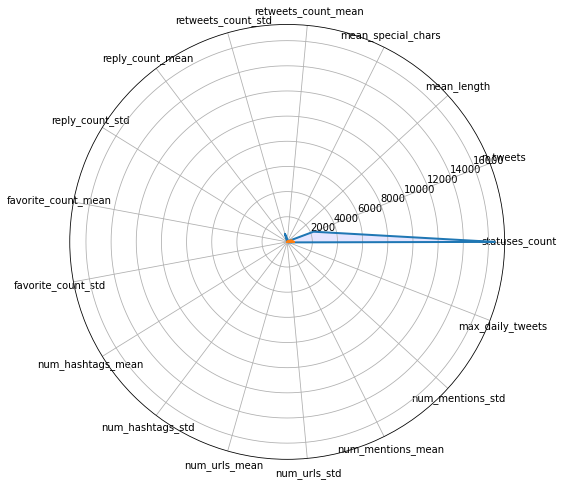

In [123]:
N = len(df_merge.columns)

plt.figure(figsize=(8,8))
for i in range(0, len(cent)):
  angles = [n / float(N)*2*math.pi for n in range(N)]
  values = cent[i].tolist()
  values += values[:1]
  angles += angles[:1]

  ax = plt.subplot(polar=True)
  plt.xticks(angles[:-1], df_merge.columns)
  ax.plot(angles, values, linewidth=2)
  ax.fill(angles, values, 'b', alpha=0.1)

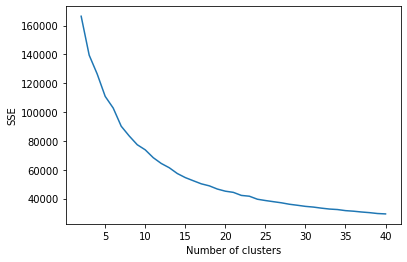

In [113]:
max_k = 40
sse_list = list()

for k in range(2, max_k+1):
  kmeans = KMeans(n_clusters=k, n_init=10, max_iter=100)
  kmeans.fit(df_merge_scaled)
  sse_list.append(kmeans.inertia_)

plt.plot(range(2, len(sse_list)+2), sse_list)
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.show()